<a href="https://colab.research.google.com/github/shreyanshxt/brain-tumor-/blob/main/BRAIN_TUMOR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install nibabel


In [5]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 38.9 MB/s eta 0:00:00


In [ ]:
Original NIfTI (.nii) files
     ↓
[ANTs Registration] → aligned_suv.nii
     ↓
[Convert to NumPy] → aligned_suv.npy + cbf.npy
     ↓
[Stack or Train]   → [SUV, CBF] as input to your ViT


In [ ]:
#convert all the files in .suv folder to a .numpy format
import os
import numpy as np
suv_folder="/content/sample_data/(.suv)"
output_folder="/content/sample_data/output_folder"
os.makedirs(output_folder,exist_ok=True)
for filename in os.listdir(suv_folder):
  if filename.endswith(".nii"):
    img=nib.load(os.path.join(suv_folder,filename))
    data=img.get_fdata()
    np.save((os.path.join(output_folder,filename.replace(".nii",".npy"))),data)




In [ ]:
#convert all the files in .cbf folder to a .numpy format
import os
import numpy as np
suv_folder="/content/sample_data/(.cbf)"
output_folder="/content/sample_data/output_folder2"
os.makedirs(output_folder,exist_ok=True)
for filename in os.listdir(suv_folder):
  if filename.endswith(".nii"):
    img=nib.load(os.path.join(suv_folder,filename))
    data=img.get_fdata()
    np.save((os.path.join(output_folder,filename.replace(".nii",".npy"))),data)




In [8]:
!pip install antspyx


In [9]:
#aligning the two suv and cbf
import nibabel as nib
import ants
import os
from os import path
import numpy as np
#loop to go through all teh files
suv_img_path="/content/sub-patient19_SUV_z.nii"
cbf_img_path="/content/sub-patient19_cbf.nii"


base, ext = os.path.splitext(suv_img_path)
cbf_img=ants.image_read(cbf_img_path)
suv_img=ants.image_read(suv_img_path)
suv_nii=nib.load(suv_img_path)
cbf_nii=nib.load(cbf_img_path)

img_cor_suv = ants.n4_bias_field_correction(suv_img)

img_cor_cbf = ants.n4_bias_field_correction(cbf_img)
# spacing
def spacing(affine):
  affine_data= affine.affine.astype(np.float64)
  return tuple(np.sqrt((affine_data[:3, :3] ** 2).sum(axis=0)))

#min max normalization
def minmax(img_ants):
  data=img_ants.numpy()
  normalized=(data-data.min())/(data.max()-data.min() + 1e-8)
  normalized = np.nan_to_num(normalized, nan=0.0, posinf=0.0, neginf=0.0)
  affine=ants_affine(img_ants)
  new_img = nib.Nifti1Image(
        normalized,
        affine
    )
  return new_img # Return the new nibabel image

# define affine matrix
def ants_affine (img_ants):
  spacing=np.array(img_ants.spacing)
  direction=np.array(img_ants.direction)
  origin=np.array(img_ants.origin)
  affine=np.eye(4)
  for i in range(3):
    affine[i,:3]=direction[i]*spacing[i]

  affine[:3,3]=origin
  return affine


norm_suv=minmax(img_cor_suv)
norm_cbf=minmax(img_cor_cbf)

#covert npy->ants
ants_suv=ants.from_numpy(norm_suv.get_fdata())
ants_cbf=ants.from_numpy(norm_cbf.get_fdata())

#registration
reg=ants.registration(fixed=ants_suv,moving=ants_cbf,type_of_transform='SyN')
aligned_suv=reg['warpedmovout']
suv_reg=base+'_registered_'+ext
ants.image_write(aligned_suv,suv_reg)

In [35]:
# edge map extraction
from scipy import ndimage
def sobel_edge_map(img_reg):
  img_ants = ants.image_read(img_reg)
  data = img_ants.numpy()
  spacing = img_ants.spacing

  sobel_x=ndimage.sobel(data,axis=0)
  sobel_y=ndimage.sobel(data,axis=1)
  sobel_z=ndimage.sobel(data,axis=2)
  edge_map=np.sqrt(sobel_x**2 +sobel_y**2 +sobel_z**2)
  edge_map_norm = (edge_map - edge_map.min()) / (edge_map.max() - edge_map.min() + 1e-8)
  edge_map_norm = np.nan_to_num(edge_map_norm, nan=0.0, posinf=0.0, neginf=0.0)
  ants_edge_img = ants.from_numpy(

      edge_map_norm,
      spacing=img_ants.spacing,
      origin=img_ants.origin,
      direction=img_ants.direction
    )
  edge_map_reg=os.path.splitext(img_reg)[0]+"_edge_map_"+os.path.splitext(img_reg)[1]

# Save as NIfTI
  ants.image_write(ants_edge_img,edge_map_reg)
img_reg="/content/sub-patient19_SUV_z_registered_.nii"
sobel_edge_map(img_reg)
img_reg="/content/sub-patient19_cbf.nii"
sobel_edge_map(img_reg)

In [33]:
import matplotlib.pyplot as plt
import ants

def plot_ants_slices(ants_img, title="Slice View"):
    data = ants_img.numpy()

    # Get center slice in each axis
    x_slice = data[data.shape[0] // 2, :, :]
    y_slice = data[:, data.shape[1] // 2, :]
    z_slice = data[:, :, data.shape[2] // 2]

    # Plot slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(x_slice.T, cmap="inferno", origin="lower")
    axes[0].set_title('Axial Slice')

    axes[1].imshow(y_slice.T, cmap="inferno", origin="lower")
    axes[1].set_title('Coronal Slice')

    axes[2].imshow(z_slice.T, cmap="inferno", origin="lower")
    axes[2].set_title('Sagittal Slice')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


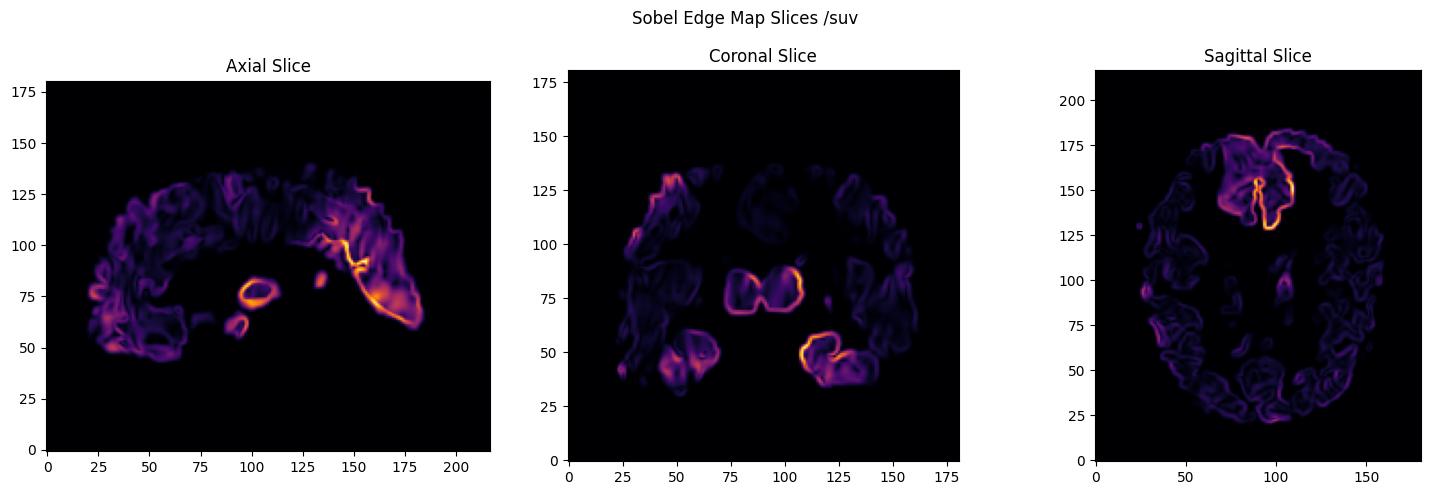

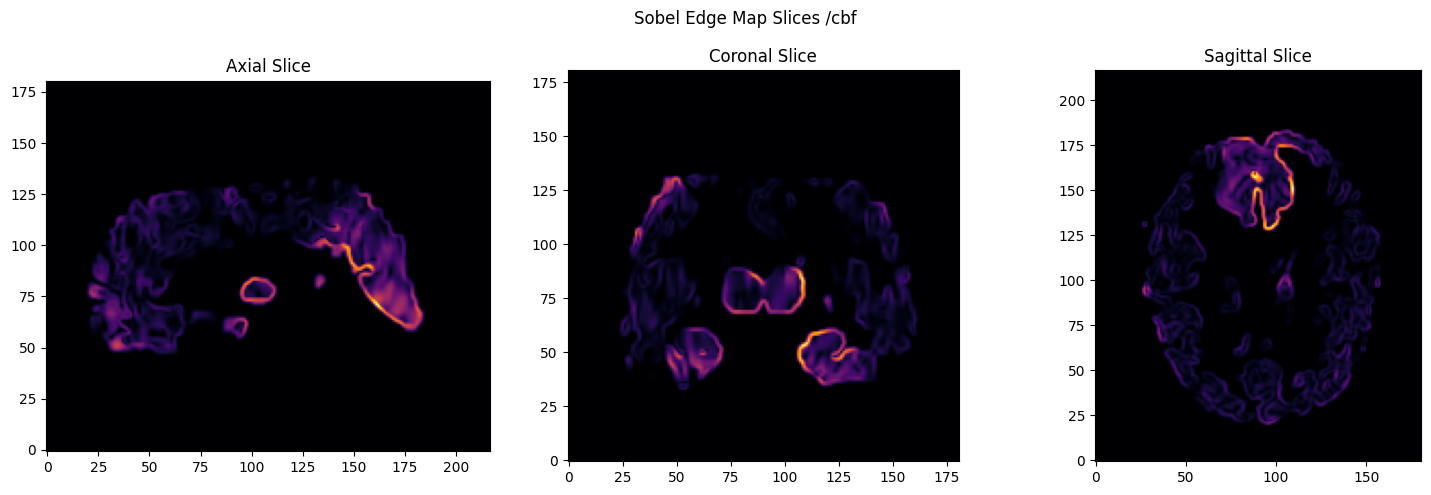

In [37]:
edge_img = ants.image_read("/content/sub-patient19_SUV_z_registered__edge_map_.nii")
plot_ants_slices(edge_img, title="Sobel Edge Map Slices /suv")
edge_img = ants.image_read("/content/sub-patient19_cbf_edge_map_.nii")
plot_ants_slices(edge_img, title="Sobel Edge Map Slices /cbf")


In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

 #encoder block
def encoder_block(inputs,filters,kernel_size=(3,3),padding='same',strides=1):
  x=layers.Conv2D(filters,kernel_size,padding,strides=strides,activation='relu')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Conv2D(filters,kernel_size,padding,strides=strides,activation='relu')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Conv2D(filters,kernel_size,padding,strides=strides,activation='relu')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Conv2D(filters,kernel_size,padding,strides=strides,activation='relu')(x)
  x=layers.BatchNormalization()(x)

  x=layers.MaxPooling2D((2,2))(x)
  return x
def fusion_model(input_shape):
  input